# DeepWAS Pipeline

## Preprocessing

Let's start with loading required libraries and defining some file paths:

In [1]:
library(data.table)

`%+%` <- paste0
vol <- './'

genfile.de1 <- vol %+% 'data/raw/DE1/MS1_functional.gen'
covarfile.de1 <- vol %+% 'data/raw/DE1/MS1_covariates_complete.txt'
phenfile.de1 <- vol %+% 'data/raw/DE1/MS1.fam'

genfile.de2 <- 'zcat ' %+% vol %+% 'data/raw/DE2/MS2_functional.gen.gz'
covarfile.de2 <- vol %+% 'data/raw/DE2/MS2_covariates_complete.txt'
phenfile.de2 <- vol %+% 'data/raw/DE2/MS2.fam'

deepsea.table <- vol %+% 'data/processed/evalueswithpos.tsv'

In [2]:
read.data <- function(genfile, phenfile, covarfile) {

  gen <- fread(genfile, header = F, sep=' ', data.table=F)
  colnames(gen)[1:6] <- c('_', 'chr', 'rsid', 'pos', 'allele1', 'allele2')
  phen <- fread(phenfile, data.table = F, col.names=c('FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENO'))
  covar <- fread(covarfile, data.table = F)

  covar$SEX   <- factor(covar$SEX, levels = c('male', 'female'))
  covar$PHENO <- factor(covar$PHENO, levels = c('ctrl', 'case'))

  nsnps <- nrow(gen)
  nsamples <- nrow(phen)

  print('Genotype mat. size:')
  print(dim(gen))
  print('Phenotype mat. size:')
  print(dim(phen))
  print('Covariate mat. size:')
  print(dim(covar))

  stopifnot((ncol(gen)-6)/3 == nsamples)
  dom.gen <- 2*as.matrix(gen[,seq(7, ncol(gen), 3)]) +
               as.matrix(gen[,seq(8, ncol(gen), 3)])

  # sort covariates based on FID
  covar <- covar[ match(phen$FID, covar$FID), ]

  stopifnot(all(covar$FID == phen$FID))
  stopifnot(all(as.numeric(covar$PHENO) == phen$PHENO))
  stopifnot(all(as.numeric(covar$SEX) == phen$SEX))

  colnames(dom.gen) <- covar$FID
  rownames(dom.gen) <- gen$rsid

  dom.gen <- as.data.frame(t(dom.gen))

  print('New genotype mat. size (sample x variant):')
  print(dim(dom.gen))

  final.covar <- covar[, c('SEX', paste0('C', 1:8))] # sex and principal comps.
  final.covar$SEX <- as.numeric(final.covar$SEX) - 1
  rownames(final.covar) <- rownames(dom.gen)

  final.pheno <- as.numeric(covar$PHENO) - 1
  
  gen.pos.snp <- gen[, c('rsid', 'chr', 'pos')]
  colnames(gen.pos.snp) <- c('gen.snp', 'gen.chr', 'gen.pos')
  gen.pos.snp$chrpos <- paste(gen.pos.snp$gen.chr, gen.pos.snp$gen.pos, sep=':')

  return(list(genotype=dom.gen, 
              covar=final.covar,
              phenotype=final.pheno,
              variantpos=gen.pos.snp))
}

In [3]:
# load genotype (in .gen format), phenotype (in .fam format) and covariate files
de1 <- read.data(genfile.de1, phenfile.de1, covarfile.de1)
gc(verbose=F)

Read 37889 rows and 37173 (of 37173) columns from 2.996 GB file in 00:05:05
[1] "Genotype mat. size:"
[1] 37889 37173
[1] "Phenotype mat. size:"
[1] 12389     6
[1] "Covariate mat. size:"
[1] 12389    12
[1] "New genotype mat. size (sample x variant):"
[1] 12389 37889


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,645916,34.5,1168576,62.5,1168576,62.5
Vcells,470919586,3592.9,2706017340,20645.3,3382511408,25806.6


In [4]:
de2 <- read.data(genfile.de2, phenfile.de2, covarfile.de2)
gc(verbose=F)

Read 37251 rows and 8688 (of 8688) columns from 0.700 GB file in 00:00:53
[1] "Genotype mat. size:"
[1] 37251  8688
[1] "Phenotype mat. size:"
[1] 2894    6
[1] "Covariate mat. size:"
[1] 2894   12
[1] "New genotype mat. size (sample x variant):"
[1]  2894 37251


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,693380,37.1,1168576,62.5,1168576,62.5
Vcells,578927270,4416.9,2164813872,16516.3,3382511408,25806.6


Count common SNPs:

In [5]:
common.snps <- intersect(colnames(de1$genotype), colnames(de2$genotype))
length(common.snps)

[1] 36409

Now merge two datasets into one:

In [6]:
merge.genotype <- rbind.data.frame(de1$genotype[, common.snps], de2$genotype[, common.snps])
merge.covar <- rbind.data.frame(de1$covar, de2$covar)
merge.covar$CHIP <- c(rep(0, nrow(de1$covar)), rep(1, nrow(de2$covar)))
merge.phenotype  <- c(de1$phenotype, de2$phenotype)
merge.variantpos <- unique(rbind.data.frame(de1$variantpos, de2$variantpos))

dim(merge.genotype)

[1] 15283 36409

Filter DeepSEA variants and save all data as a list in an RDS file:

In [7]:
# Load evalues 
deepsea <- fread(deepsea.table,
                 col.names = c('snp', 'mineval.feature.uniq', 'mineval.feature', 'eval',
                               'chr', 'pos', 'al1', 'al2'),
                 data.table=F)

deepsea$chrpos <- paste(deepsea$chr, deepsea$pos,  sep= ':')
head(deepsea)

Read 1841459 rows and 8 (of 8) columns from 0.150 GB file in 00:00:04


snp,mineval.feature.uniq,mineval.feature,eval,chr,pos,al1,al2,chrpos
1:100110955:G:A,HepG2.p300.None.1,HepG2|p300|None,4.5593e-05,1,100110955,G,A,1:100110955
1:100121489:CGCACACACACACACAT:C,H1.hESC.H2AZ.None,H1-hESC|H2AZ|None,3.6475e-05,1,100121489,CGCACACACACACACAT,C,1:100121489
1:100121489:CGCACACACACACACAT:C,H1.hESC.H3K23me2.None,H1-hESC|H3K23me2|None,2.5330e-05,1,100121489,CGCACACACACACACAT,C,1:100121489
1:100183350:T:C,H1.hESC.H3K79me2.None,H1-hESC|H3K79me2|None,2.0264e-06,1,100183350,T,C,1:100183350
1:100183350:T:C,NHLF.H4K20me1.None,NHLF|H4K20me1|None,1.0132e-06,1,100183350,T,C,1:100183350
1:100183350:T:C,NHDF.Ad.H4K20me1.None,NHDF-Ad|H4K20me1|None,1.0132e-05,1,100183350,T,C,1:100183350


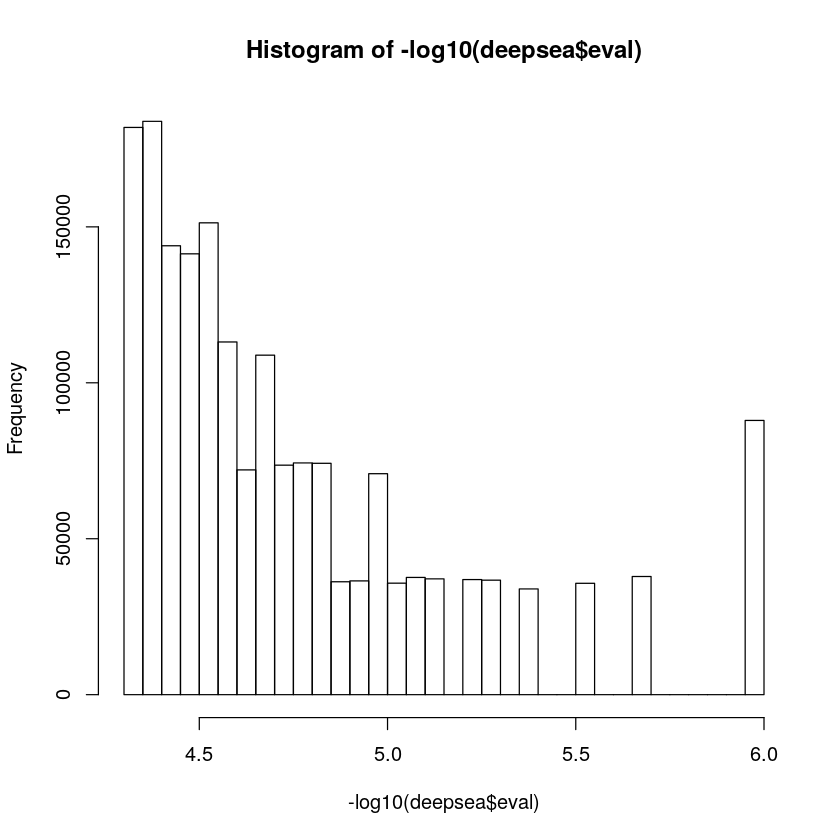

In [8]:
hist(-log10(deepsea$eval), breaks = 30)

In [9]:
prepare.res <- function(dom.gen, final.covar, final.pheno, gen.pos.snp, snp.eval) {

  # add position information from genotypes
  snp.eval <- merge(snp.eval, gen.pos.snp, by = 'chrpos')    
  snp.eval <- snp.eval[snp.eval$gen.snp %in% colnames(dom.gen), ]

  variantpos <- unique(snp.eval[, c('gen.snp', 'gen.chr', 'gen.pos')])
  stopifnot(ncol(variantpos) == 3)

  snp.eval$snp <- snp.eval$gen.snp
  stopifnot(ncol(dom.gen) == length(unique(snp.eval$snp)))
  snp.eval.split <- split(snp.eval$snp, snp.eval$mineval.feature.uniq)
  snp.eval.split.len <- sapply(snp.eval.split, length)
  
  # Save names of DeepSEA features
  features.uniq <- unique(snp.eval$mineval.feature.uniq)
  feature.mapping <- unique(snp.eval[,c('mineval.feature.uniq', 'mineval.feature')])
  features <- feature.mapping[match(features.uniq, feature.mapping$mineval.feature.uniq),]$mineval.feature
  
  res <- list(x=dom.gen,
              covar=final.covar,
              y=final.pheno,
              snp.eval=snp.eval,
              snp.eval.split=snp.eval.split,
              features=features,
              features.uniq=features.uniq,
              variantpos = variantpos)
  res
}

dw <- prepare.res(merge.genotype, merge.covar, merge.phenotype, merge.variantpos, deepsea)
saveRDS(dw, 'deepwas-dataset.Rds', compress = F)

## Fit LASSO models using stability selection

In [10]:
library(stabs)

ncores <- 10

Loading required package: parallel


In [11]:
#dw <- readRDS('deepwas-dataset.Rds')

In [12]:
fit.stabs <- function(res, stabs.cutoff=0.7, stabs.PFER=1.0, logistic=T) {

  if (logistic) {
    fitfun = glmnet.lasso
    args.fitfun = list(alpha=1, family='binomial')
  } else {
    fitfun = lars.lasso
    args.fitfun = list()
  }
    
  fits <- mclapply(res$features.uniq, function(feature) {
    print(feature)

    mat <- cbind(res$x[, unique(res$snp.eval.split[[feature]])],
                 res$covar)

    f <- try(stabsel(mat, res$y, cutoff = stabs.cutoff, PFER = stabs.PFER,
                     fitfun = fitfun, args.fitfun = args.fitfun,
                     papply = lapply))

    if(class(f)=='try-error')return(NULL)
    f
  }, mc.cores = ncores)

  names(fits) <- res$features.uniq
  fits
}

models <- fit.stabs(dw)
saveRDS(models, 'deepwas-results.Rds', compress=F)

## Save results

In [13]:
library(dplyr)
library(tidyr)

selected.single <- function(e, covars){paste(setdiff(unique(names(selected(e))), covars), collapse = ',')}

extract.df <- function(res, dw, cutoff=0.7, pfer=1.0) {

 covar.names <- colnames(dw$covar)
 features <- dw$features
 features.uniq <- dw$features.uniq
 feat.split <- strsplit(features, '\\|')
 variantpos <- dw$variantpos
    
 feature.map <- data.frame(features=features,
                           features.uniq=features.uniq,
                           cell.line=sapply(feat.split, `[[`, 1),
                           tf=sapply(feat.split, `[[`, 2),
                           treatment=sapply(feat.split, `[[`, 3),
                           hits=gsub('`', '', sapply(res, selected.single, covars=covar.names)),
                           cutoff=cutoff,
                           pfer=pfer,
                           stringsAsFactors = F)
      
 feature.map <- transform(feature.map, hits=strsplit(hits, ',')) %>% unnest(hits)
 feature.map <- merge(feature.map, variantpos, by.x='hits', by.y='gen.snp') # add variant position info
 feature.map
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [14]:
hits.df <- extract.df(models, dw)

# exclude MHC hits chromosome 6 (base pair positions 27-35Mb
hits.df <- subset(hits.df, !(gen.chr == 6 & gen.pos > 27000000 & gen.pos < 35000000))
head(hits.df)

,hits,features,features.uniq,cell.line,tf,treatment,cutoff,pfer,gen.chr,gen.pos
1,1-16190241,PBDE|GATA-1|None,PBDE.GATA.1.None,PBDE,GATA-1,None,0.7,1,1,16190241
2,17-58024224,HeLa-S3|EZH2|None,HeLa.S3.EZH2.None,HeLa-S3,EZH2,None,0.7,1,17,58024224
5,rs1000329,HUVEC|Max|None,HUVEC.Max.None,HUVEC,Max,None,0.7,1,19,16449517
6,rs1034919,Gliobla|CTCF|None,Gliobla.CTCF.None,Gliobla,CTCF,None,0.7,1,1,117075505
7,rs1034919,GM06990|CTCF|None,GM06990.CTCF.None,GM06990,CTCF,None,0.7,1,1,117075505
8,rs1034919,K562|CTCFL|None,K562.CTCFL.None,K562,CTCFL,None,0.7,1,1,117075505


In [15]:
length(unique(hits.df$hits))

[1] 53

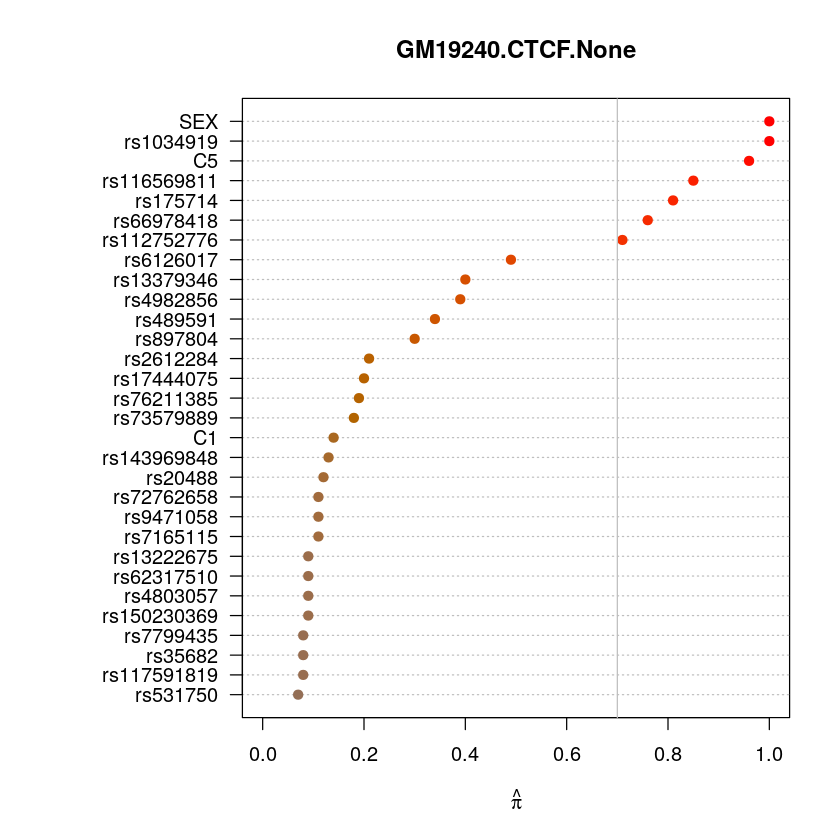

In [16]:
n.hits <- hits.df %>% group_by(features.uniq) %>% summarise(n=n_distinct(hits))

best.feat <- n.hits$features.uniq[order(n.hits$n, decreasing = T)[1]]
best.model <- models[[best.feat]]

plot.stabsel(best.model, main=best.feat, np=30)